Num samples: 80000
Height: 4, Aspect: 1.0


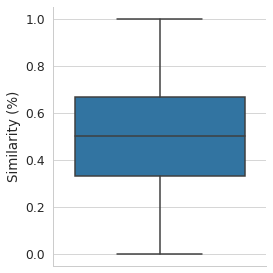

In [15]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse
import random

# script_n = os.path.basename(__file__).split('.')[0]


sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData



# ap = argparse.ArgumentParser()
# ap.add_argument("--min_length", type=int, default=4)
# ap.add_argument("--max_dist", type=int, default=125)
# ap.add_argument("--n_random", type=int, default=20)
# ap.add_argument("--n_sample", type=int, default=10000)
# config = ap.parse_args()
max_dist = 150
min_length = 4
n_sample = 80000
script_n = 'pfs_pattern_similarity_210101'


from weight_database import WeightDatabase
weightdb = WeightDatabase()

weightdb.load_syn_db('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/pfs/gen_210101_setup01_syndb_threshold_10_coalesced_filtered_10.gz')
weightdb.load_touch_db(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/purkinje/db_pf_contacts_201224.gz',
    max_dist=max_dist
    )

postsyns = list(weightdb.get_presyn_ids())
hist = defaultdict(list)

def calc_pattern_similarity(weightdb, type='Data'):
    mpd = MyPlotData()
    processed = set()
    n = 0
    random.seed(0)
    while n < n_sample:
        pc0 = postsyns[int(random.random()*len(postsyns))]
        pc1 = postsyns[int(random.random()*len(postsyns))]
        if pc0 == pc1:
            continue
        if (pc0, pc1) in processed:
            continue
        processed.add((pc0, pc1))
        processed.add((pc1, pc0))
        if len(weightdb.get_shared_presyns(pc0, pc1)) < min_length:
            continue
        score = weightdb.calc_pattern_similarity(pc0, pc1)
        # if score >= 0.7:
        #     print(f'{pc0} and {pc1}: {score}')
        mpd.add_data_point(
            score=score,
            type=type,
            )
        n += 1
        hist[type].append(score)
    print(f'Num samples: {n}')
    return mpd


mpd_data = calc_pattern_similarity(weightdb)

mpd_all = MyPlotData()
mpd_all.append(mpd_data)
# mpd_all.append(mpd_random)

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    y="score",
    # x="type",
    # ylim=[.30, .70],
    context='paper',
    kind='box',
    # add_swarm=True,
    height=4,
    width=4,
    y_axis_label='Similarity (%)',
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )

import compress_pickle
compress_pickle.dump(
    mpd_data,
    f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_db.gz',)

